In [1]:
# Some imports to get us started
import warnings
warnings.simplefilter('ignore')

# Utilities
import os
import urllib.request
import numpy as np
import pandas as pd
from networkx.drawing.nx_pydot import to_pydot
from IPython.display import Image, display

# Generic ML imports
from xgboost import XGBRegressor, XGBClassifier

# EconML imports
from econml.dr import LinearDRLearner

# DoWhy imports 
import dowhy
from dowhy import CausalModel

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
data=pd.read_csv('C:/Users/AdamDavis/Downloads/hotel_bookings.csv')
#shuffle data for randomness
data=data.sample(frac = 1)

In [3]:
##add generic discount column to random rows
##will use refund or not as well as the discount
data['discount']=np.random.choice([0, 1], size=(len(data),), p=[3./5, 2./5])

In [4]:
##total length of stay from weeknights and weekdays
data['length_of_stay']=data['stays_in_weekend_nights']+data['stays_in_week_nights']
data=data[ data.length_of_stay <=7 ]
data=data[data.length_of_stay>0]
data=data[data.adr<5000]
data['total_charge']=data['length_of_stay']*data['adr']
data = data[data["deposit_type"].str.contains("No Deposit") == False]
dep_map = {'Refundable': 1, 'Non Refund': 0}
data["refund_or_non"] = data['deposit_type'].apply(lambda x: dep_map[x])

##one hot encode based off of the separate indicators
cat_cols=['hotel']
##rejoin original data
one_hot_data=pd.get_dummies(data[cat_cols])
##delete columns that were joined
data=data.drop(['hotel'],axis=1)
data=pd.concat([data,one_hot_data],axis=1)

##columns that aren't needed for analysis.  general take on this project is that previous activity and more
##generic information would have more impact on analysis.  
data = data.drop(columns=['is_repeated_guest', 'is_canceled','index', 
                            'arrival_date_year','arrival_date_day_of_month','arrival_date_month', 
                            'stays_in_weekend_nights','children','days_in_waiting_list',
                            'stays_in_week_nights', 'meal','country', 'distribution_channel','reserved_room_type',
                            'assigned_room_type', 'deposit_type', 'agent','company','arrival_date_week_number',
                            'customer_type','reservation_status', 'reservation_status_date','babies','adr',
                            'required_car_parking_spaces', 'booking_changes','total_of_special_requests','adults'
                            ,'market_segment','length_of_stay'],axis=1)

In [5]:
Treatments = data[ ["discount","refund_or_non"]]  # multiple interventions, or treatments
Y = data["total_charge"]  # total charge each customer
X = data[["lead_time"]]  # heterogeneity feature

W = data.drop(
    columns=["discount","refund_or_non","total_charge","lead_time"]
)  # controls

confounder_names = W.columns.tolist()

treatment_names = ["Refund_Status", "Discount", "Refund & Discount"]

In [6]:
# Average customer size per incentive combination
data[["lead_time", "refund_or_non","discount"]].groupby(
    by=["refund_or_non","discount"], as_index=False
).mean().astype(int)

,refund_or_non,discount,lead_time
0,0,0,213
1,0,1,212
2,1,0,144
3,1,1,161


In [7]:
# Transform T to one-dimensional array with consecutive integer encoding
def treat_map(t):
    return np.dot(t, 2 ** np.arange(t.shape[0]))

In [8]:
T = np.apply_along_axis(treat_map, 1, Treatments).astype(int)
data["discrete_T"] = T

In [9]:
# initiate an EconML cate estimator
est = LinearDRLearner(
    model_regression=XGBRegressor(learning_rate=0.1, max_depth=3),
    model_propensity=XGBClassifier(learning_rate=0.1, max_depth=3, objective="multi:softprob"),
    random_state=1,
)

In [10]:
# fit through dowhy
test_customers = X.iloc[:150].values
est_dw = est.dowhy.fit(Y, T, X=X, W=W, outcome_names=["total_charge"], treatment_names=["discrete_T"], feature_names=["lead_time"],
               confounder_names=confounder_names, target_units=test_customers)

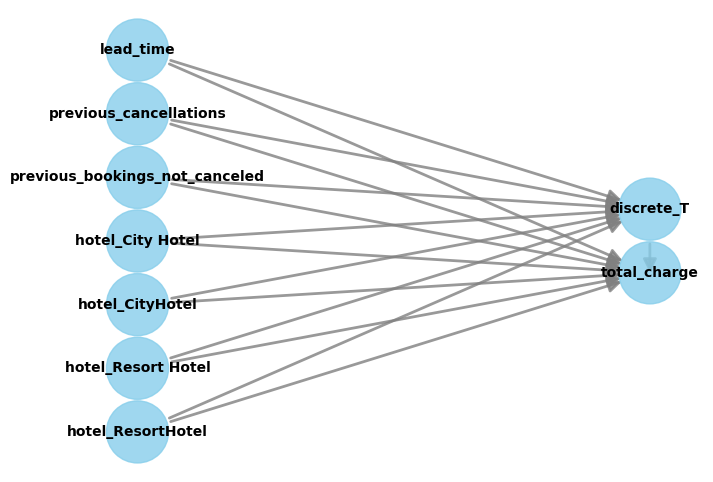

In [11]:
# Visualize causal graph
try:
    # Try pretty printing the graph. Requires pydot and pygraphviz
    display(
        Image(to_pydot(est_dw._graph._graph).create_png())
    )
except:
    # Fall back on default graph view
    est_dw.view_model(layout=None) 

In [12]:
identified_estimand = est_dw.identified_estimand_
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                       
─────────────(E[total_charge|hotel_ResortHotel,previous_bookings_not_canceled,
d[discrete_T]                                                                 

                                                                              
hotel_City Hotel,previous_cancellations,lead_time,hotel_Resort Hotel,hotel_Cit
                                                                              

        
yHotel])
        
Estimand assumption 1, Unconfoundedness: If U→{discrete_T} and U→total_charge then P(total_charge|discrete_T,hotel_ResortHotel,previous_bookings_not_canceled,hotel_City Hotel,previous_cancellations,lead_time,hotel_Resort Hotel,hotel_CityHotel,U) = P(total_charge|discrete_T,hotel_ResortHotel,previous_bookings_not_canceled,hotel_City Hotel,previous_cancellations,lead_time,hotel_Resort Ho

In [13]:
lineardml_estimate = est_dw.estimate_
print(lineardml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                       
─────────────(E[total_charge|hotel_ResortHotel,previous_bookings_not_canceled,
d[discrete_T]                                                                 

                                                                              
hotel_City Hotel,previous_cancellations,lead_time,hotel_Resort Hotel,hotel_Cit
                                                                              

        
yHotel])
        
Estimand assumption 1, Unconfoundedness: If U→{discrete_T} and U→total_charge then P(total_charge|discrete_T,hotel_ResortHotel,previous_bookings_not_canceled,hotel_City Hotel,previous_cancellations,lead_time,hotel_Resort Hotel,hotel_CityHotel,U) = P(total_charge|discrete_T,hotel_ResortHotel,previous_bookings_not_canceled,hotel_City Hotel,

In [14]:
for i in range(est_dw._d_t[0]):
    print(f"Investment: {treatment_names[i]}")
    display(est_dw.summary(T=i + 1, feature_names=["lead_time"]))

Investment: Refund_Status


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
lead_time,0.012,0.011,1.099,0.272,-0.01,0.034
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,-0.775,3.356,-0.231,0.817,-7.353,5.802


Investment: Discount


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
lead_time,-0.155,0.182,-0.85,0.395,-0.512,0.202
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,95.736,67.083,1.427,0.154,-35.745,227.217


Investment: Refund & Discount


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
lead_time,-0.264,0.155,-1.709,0.087,-0.568,0.039
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,106.145,48.69,2.18,0.029,10.714,201.576


In [15]:
# Define cost function. 
def cost_fn(multi_data):
    #penalty for each previous_cancellation of $10. Penalty.
    #essentially the cost of potential refund. penalized more with more previous cancellations.
    t1_cost = data[["previous_cancellations"]].values * -10
    #discount is 10% of total charge of guest
    t2_cost = data[["total_charge"]].values * .10
    return np.hstack([t1_cost, t2_cost, t1_cost + t2_cost])

In [16]:
# Get roi for each customer and possible treatment
potential_roi = est_dw.const_marginal_effect(X=X.values) - cost_fn(data)
# Add a column of 0s for no treatment
potential_roi = np.hstack([np.zeros(X.shape), potential_roi])

In [17]:
all_treatments = np.array(["None"] + treatment_names)
recommended_T = np.argmax(potential_roi, axis=1)

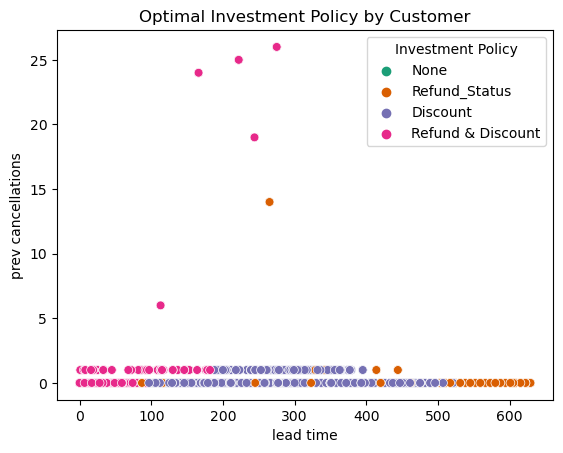

In [18]:
ax1 = sns.scatterplot(
    x=X.values.flatten(),
    y=data["previous_cancellations"].values,
    hue=all_treatments[recommended_T],
    hue_order=all_treatments,
    palette="Dark2",
    s=40,
)
plt.legend(title="Investment Policy")
plt.setp(
    ax1,
    xlabel="lead time",
    ylabel="prev cancellations",
    title="Optimal Investment Policy by Customer",
)
plt.show()

In [19]:
roi_current = potential_roi[np.arange(X.shape[1]), T].sum()
roi_optimal = potential_roi[np.arange(X.shape[1]), recommended_T].sum()
roi_bothT = potential_roi[:, -1].sum()
all_rois = np.array([roi_optimal, roi_current, roi_bothT])
Y_baseline = (Y - est_dw.effect(X=X.values, T1=T)).sum()

In [20]:
pd.DataFrame(
    {
        "Policy": ["Optimal Strategy", "Current Stretegy", "All Investments"],
        "ROI ($)": all_rois,
        "ROI (% of baseline Y)": np.round(all_rois / Y_baseline * 100, 1),
    }
)

,Policy,ROI ($),ROI (% of baseline Y)
0,Optimal Strategy,483556.433896,13.6
1,Current Stretegy,79796.886725,2.2
2,All Investments,435719.105838,12.2


In [21]:
res_random = est_dw.refute_estimate(method_name="random_common_cause", num_simulations=10)
print(res_random)

Refute: Add a random common cause
Estimated effect:1.8103842700952948
New effect:1.578177541534503
p value:0.2191116982229836



In [22]:
res_unobserved = est_dw.refute_estimate(method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
    effect_strength_on_treatment=0.3, effect_strength_on_outcome=0.5)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:1.8103842700952948
New effect:2.084578597067934



In [23]:
res_placebo = est_dw.refute_estimate(
    method_name="placebo_treatment_refuter", placebo_type="permute", 
    num_simulations=5
)
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:1.8103842700952948
New effect:0.7453691243084528
p value:0.34254096919240806



In [24]:
# Removing a random subset of the data
res_subset = est_dw.refute_estimate(
    method_name="data_subset_refuter", subset_fraction=0.8, 
    num_simulations=3)
print(res_subset)

Refute: Use a subset of data
Estimated effect:1.8103842700952948
New effect:1.0603942943785114
p value:0.20404994657634468

